#### Simulation by Omar ELGHAFFOULI

In [3]:
# import the necessary libraries 
import pandas as pd 
import numpy as np
from random import *
from math import *

In [4]:
# import the data 
df=pd.read_table('acc_usines.txt', header=None, names=["num_acc"])
df.head()

num_acc
0        4
1        5
2        4
3        1
4        0

In [5]:
y=np.array(df.num_acc) # convert the data into array 
T=len(y)  # length of data 

 y contains our data. In the next cells, we will be using the following notations in code :
 
 l denotes $\lambda$, le point de changement 
        
d: denotes $\delta$, the poisson parameter if t>l
        
g: denotes $\gamma$, the poisson parameter if t<=l

#### Utility Functions 

$ S_{k}=\sum_{t=1}^{k}{y_{t}}$

In [41]:
# for l=k, calculate the sum of y_t from 1 til k
#this sum appears in the conditional distribution of l
#please refer to the excercice solution
def s(k:int):       
    s=0
    for i in range(k+1):
        s+=y[i] 
    return s        # returns a sum 

$ \bar{S_{k}}=\sum_{k+1}^{T}{y_{t}}$

In [42]:
# for l=k, calculate the sum of y_t from k+1 til T
#this sum appears in the conditional distribution of l
# please refer to the exercice solution 
def s_barre(k:int):
    s_barre=0
    for i in range(k+1,(len(y))):
        s_barre+=y[i]
    return s_barre            # returns a sum 

$\mathbb{P}\left(\lambda=k\mid \gamma,\delta,y\right)=\frac{\exp\left(-k(\gamma-\delta\right)\gamma^{S_{k}}\delta^{\bar{S_{k}}}}{\sum_{k=1}^{T-1}\exp\left(-k(\gamma-\delta\right)\gamma^{S_{k}}\delta^{\bar{S_{k}}}}$


In [10]:
# la loi de probabilité marginale de lambda(l) sachant gamma(g), delta(d) et y
# c'est la posteriori de l sachant les autres paramètres  
def P(l,d,g):
    nom=0
    for j in range(1,len(y)):
        nom+=(np.exp(-j*(g-d)))*(g**(s(j)))*(d**(s_barre(j)))
    
    p=(np.exp(-l*(g-d)))*(g**(s(l)))*(d**(s_barre(l)))
    proba_cond_lambda=(p/nom)
    
    return proba_cond_lambda 

In [12]:
_lambda=range(1,len(y))         # the range the possible values of lmabda(l)

In [13]:
# retourne une liste de probalités de chaque valeurs de lambda sachant g,d et y
# utile pour la simulation de la loi de l
def list_proba_cond_lambda(d,g):
    list_proba_cond_lambda=[]
    for e in _lambda:
        list_proba_cond_lambda.append(P(e,d,g))
    return list_proba_cond_lambda

In [14]:
# retourne un entier entre 1 et T-1 
# la focntion simule la loi de l 
def simul(valeurs,probas):
    assert len(valeurs)==len(probas)
    nb=random()
    curseur=0
    for i in range(len(valeurs)):
        if curseur<=nb and nb<curseur+probas[i]:
            return valeurs[i]
        else: 
            curseur+=probas[i]

#### Algorithme de gibbs pour la simulation des lois posteriori des trois paramètres 

$\gamma\mid \delta,\lambda, y \sim G(a_1+S_{\lambda},\lambda+a_{2})$

$\delta\mid \gamma,\delta,y \sim G(d_{1}+\bar{S_{\lambda}},T-\lambda+d_{2})$


$\mathbb{P}\left(\lambda=k\mid \gamma,\delta,y\right)=\frac{\exp\left(-k(\gamma-\delta\right)\gamma^{S_{k}}\delta^{\bar{S_{k}}}}{\sum_{k=1}^{T-1}\exp\left(-k(\gamma-\delta\right)\gamma^{S_{k}}\delta^{\bar{S_{k}}}}$


In [15]:
def gibbs_sampling(g_0,d_0,l_0,a_1,a_2,d_1,d_2,n_iter):
    sample=np.empty((n_iter,3), dtype=float)
    l=l_0
    for k in range(n_iter):
        L=[]
        g_k=np.random.gamma(a_1+s(l), (1/(l+a_2)))
        d_k=np.random.gamma(d_1+s_barre(l),(1/(T-l+d_2)))
        l_k=simul(_lambda,list_proba_cond_lambda(d_k,g_k))
        L.append(g_k)
        L.append(d_k)
        L.append(l_k)
        sample[k]=L
        l=l_k
    return sample

In [16]:
# taille de l'échantillon 200 
# initialisation des paramètres 
sample_=gibbs_sampling(0,0,1,0,0,0,0,200) 

In [44]:
# as we know, les MCMC convergent vers la vraie distribution quand n_iter tend vers l'infini
# ici, on a pris les 100 derniers échantillons 
sample=sample_[100:]  

In [29]:
# représentation des échantillons sous forme d'un dataframe for easy manipulations
dd=pd.DataFrame(sample,columns=['g','d','l'])
dd.head()

g         d     l
0  3.479424  0.931949  35.0
1  3.528910  0.937035  35.0
2  3.616757  0.858208  41.0
3  3.201354  0.824543  41.0
4  2.945311  0.857086  38.0

In [30]:
# génération des statistiques 
dd.describe()

g           d           l
count  100.000000  100.000000  100.000000
mean     3.209230    0.893896   38.780000
std      0.307484    0.106770    2.389286
min      2.462608    0.604916   34.000000
25%      2.987881    0.823685   38.000000
50%      3.199654    0.894752   39.000000
75%      3.412206    0.962149   40.000000
max      4.211965    1.117734   45.000000

#### Représentation graphiques des postérioris des 3 paramètres 

###### 1/ Postériori de Lambda 

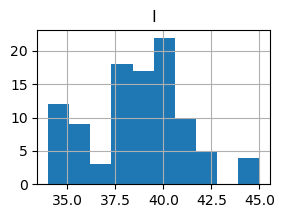

In [46]:
hist=dd.hist(column='l',figsize=(3,2))

###### 2/ Postériori de gamma 

array([[<AxesSubplot: title={'center': 'g'}>]], dtype=object)

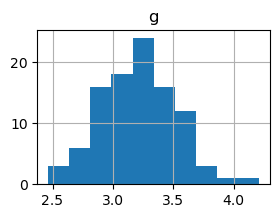

In [39]:
dd.hist(column='g',figsize=(3,2))

###### 3/ Postériori de delda 

array([[<AxesSubplot: title={'center': 'd'}>]], dtype=object)

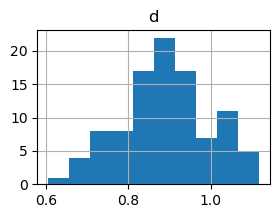

In [40]:
dd.hist(column='d',figsize=(3,2))

#### Calcul du nombre d’accidents avant et aprés ce changement ?

In [23]:
s(39)

125

In [24]:
s_barre(39)

66

In [25]:
s(41)

128

In [26]:
s_barre(41)

63

In [27]:
s(37)

120

In [28]:
s_barre(37)

71

#### Interprétation & Conclusion

D'après les statistiques issues des lois a postériori, le point de changement $\lambda$(mean=39, std=2)

est situé entre 1888 et 1892. le nombre d'accident avant le point de changement est entre 120 et
 
128. Ainsi, le nombre d'accident après le point de changement a diminué et situé entre 63 et 71.